# 160. Keras 내장 사전 훈련 모델을 이용한 Transfer Learning 

- ResNet50 pre-trained model 사용

- 1000 개의 class 분류 모델인 ResNet50 을 binary classifier (cat, dog) 으로 변형

- google colab 사용  

- My Drive 에 training data upload

# STEP #1: IMPORT LIBRARIES

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

import tensorflow as tf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random 

In [2]:
tf.__version__

'2.0.0'

# STEP #2: IMPORT MODEL WITH PRE-TRAINED WEIGHTS

In [3]:
model = tf.keras.applications.ResNet50(weights = 'imagenet')

# STEP #3: EVALUATE THE PRE-TRAINED MODEL

**tf.keras.preprocessing.image.load_img** - image 를 PIL (Python Image Library) format 으로 load

In [7]:
Sample_Image= tf.keras.preprocessing.image.load_img(r'datasets/Transfer Learning Data/train/cats/cat.1.jpg', target_size = (224, 224))

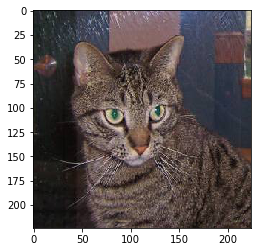

In [8]:
plt.imshow(Sample_Image)

**tf.keras.preprocessing.image.img_to_array** - PIL image 를 numpy array 로 변경

In [9]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)

In [10]:
np.shape(Sample_Image)

(224, 224, 3)

In [11]:
Sample_Image = np.expand_dims(Sample_Image, axis = 0)
np.shape(Sample_Image)

(1, 224, 224, 3)

### ResNet50 의 입력 spec 에 맞도록 Sample_Image preprocessing

In [12]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)

In [13]:
predictions = model.predict(Sample_Image)
print(predictions.shape)
print(predictions[0,:10])

(1, 1000)
[3.2660535e-06 1.9151514e-06 5.0984494e-07 7.1587292e-06 2.6283328e-06
 9.8125010e-06 6.1672006e-07 1.3496044e-06 2.0055077e-06 4.6504059e-07]


### 확률 분포로 반환된 prediction 을 category name 으로 decode

In [14]:
print('predictions:', tf.keras.applications.resnet50.decode_predictions(predictions, top = 5)[0])

predictions: [('n02123045', 'tabby', 0.710385), ('n02123159', 'tiger_cat', 0.17781742), ('n02124075', 'Egyptian_cat', 0.06622934), ('n02127052', 'lynx', 0.006393834), ('n03958227', 'plastic_bag', 0.003955259)]


### ImageDataGenerator 이용

In [13]:
image_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function= tf.keras.applications.resnet50.preprocess_input)

train_generator = image_datagen.flow_from_directory('/content/drive/My Drive/datasets/Transfer Learning Data/train/', 
                                                   target_size = (224, 224),
                                                   color_mode = 'rgb',
                                                   batch_size = 32,
                                                   class_mode = 'categorical',
                                                   shuffle = True)

Found 202 images belonging to 2 classes.


# STEP #4: TRANSFER LEARNING 적용 및 model RETRAIN 

- ResNet50 의 top layer 제거 (include_top = False)
- GlobalAaveragePooling2D + Dense() layer 5 개 추가
    - global_average_layer = keras.layers.GlobalAveragePooling2D()(base_model.output)
    - prediction_layer = keras.layers.Dense(units=2, activation='softmax')(global_average_layer)

In [14]:
base_model = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False)
full_model    = tf.keras.applications.ResNet50(weights= 'imagenet', include_top = True)

94773248/94765736 [==============================] - 8s 0us/step


In [15]:
print(full_model.summary())

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [16]:
for layer in base_model.layers[-5:]:
    print(layer.name)
print()
for layer in full_model.layers[-7:]:
    print(layer.name)

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out

conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
probs


### base model 의 마지막에 5 개 layer 추가

In [0]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
preds = tf.keras.layers.Dense(2, activation = 'softmax')(x)

In [0]:
model = tf.keras.models.Model(inputs = base_model.input, outputs = preds)

In [19]:
for layer in model.layers[-10:]:
    print(layer.name)

conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
global_average_pooling2d
dense
dense_1
dense_2
dense_3
dense_4


### Fine tuning 하기 전에 새로이 add 한 layer 들을 1 차 training 하여 초기화

In [0]:
for layer in model.layers[:-5]:
    layer.trainable = False

for layer in model.layers[-5:]:
    layer.trainable = True

In [0]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
model.fit_generator(generator = train_generator,  epochs = 5)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 7 steps
Epoch 1/5
7/7 [==============================] - 86s 12s/step - loss: 2.1895 - accuracy: 0.5941
Epoch 2/5
7/7 [==============================] - 1s 151ms/step - loss: 0.3059 - accuracy: 0.8564
Epoch 3/5
7/7 [==============================] - 1s 156ms/step - loss: 0.3539 - accuracy: 0.9109
Epoch 4/5
7/7 [==============================] - 1s 148ms/step - loss: 0.1791 - accuracy: 0.9257
Epoch 5/5
7/7 [==============================] - 1s 149ms/step - loss: 0.0921 - accuracy: 0.9604


In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

### 마지막 50 개 layer 만 fine tuning

In [0]:
for layer in model.layers[:-50]:
    layer.trainable = False

In [0]:
for layer in model.layers[-50:]:
    layer.trainable = True

In [0]:
model.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

- steps_per_epoch : Total number of steps (batches of samples) to yield from generator

In [27]:
history = model.fit_generator(generator = train_generator, steps_per_epoch=train_generator.n//train_generator.batch_size, epochs = 10)

  ...
    to  
  ['...']
Train for 6 steps
Epoch 1/10
6/6 [==============================] - 5s 789ms/step - loss: 1.3576 - accuracy: 0.8471
Epoch 2/10
6/6 [==============================] - 1s 169ms/step - loss: 0.1762 - accuracy: 0.9529
Epoch 3/10
6/6 [==============================] - 1s 173ms/step - loss: 0.1219 - accuracy: 0.9824
Epoch 4/10
6/6 [==============================] - 1s 176ms/step - loss: 0.0107 - accuracy: 1.0000
Epoch 5/10
6/6 [==============================] - 1s 175ms/step - loss: 2.4155e-05 - accuracy: 1.0000
Epoch 6/10
6/6 [==============================] - 1s 191ms/step - loss: 2.1057e-07 - accuracy: 1.0000
Epoch 7/10
6/6 [==============================] - 1s 173ms/step - loss: 6.3236e-10 - accuracy: 1.0000
Epoch 8/10
6/6 [==============================] - 1s 181ms/step - loss: 6.3236e-10 - accuracy: 1.0000
Epoch 9/10
6/6 [==============================] - 1s 175ms/step - loss: 6.3236e-10 - accuracy: 1.0000
Epoch 10/10
6/6 [==============================] - 1s 1

# STEP #5: EVALUATE THE MODEL

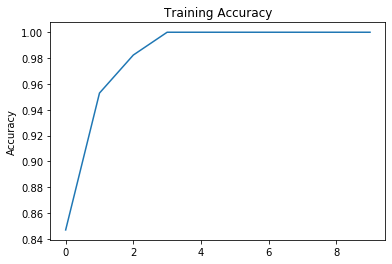

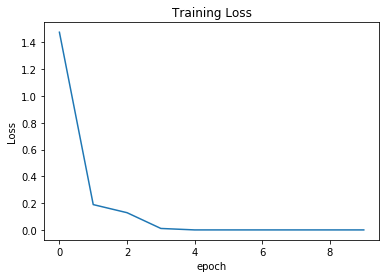

In [28]:
acc = history.history['accuracy']
loss = history.history['loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.figure()

plt.plot(loss, label='Training Loss')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.show()

In [0]:
Sample_Image= tf.keras.preprocessing.image.load_img(r'/content/drive/My Drive/datasets/Transfer Learning Data/cat.282.jpg', target_size = (224, 224))

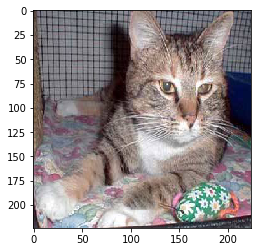

In [30]:
plt.imshow(Sample_Image)

In [31]:
Sample_Image = tf.keras.preprocessing.image.img_to_array(Sample_Image)
np.shape(Sample_Image)

(224, 224, 3)

In [0]:
Sample_Image = np.expand_dims(Sample_Image, axis = 0)


In [33]:
Sample_Image = tf.keras.applications.resnet50.preprocess_input(Sample_Image)
predictions = model.predict(Sample_Image)
print('Predictions:', predictions)

Predictions: [[1. 0.]]
